In [ ]:
"""!pip install finrl
!pip install alpaca_trade_api
!pip install exchange_calendars
!pip install stockstats
!pip install wrds
!pip install yfinance"""

# %pip install exchange_calendars yfinance finrl stockstats wrds alpaca_trade_api gymnasium matplotlib numpy pandas seaborn stable-baselines3 ale-py gym-anytrading tqdm scipy scikit-learn dask-ml tqdm rich


'!pip install finrl\n!pip install alpaca_trade_api\n!pip install exchange_calendars\n!pip install stockstats\n!pip install wrds\n!pip install yfinance'

In [13]:
import os
import pandas as pd
import numpy as np
import yfinance as yf
import heapq
import random
import torch
from scipy.spatial import KDTree
from torch import nn
import itertools
import IPython.display
import gc
from tqdm import tqdm
import re
import copy  

import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gymnasium import spaces
from gymnasium.utils import seeding
from stable_baselines3.common.vec_env import DummyVecEnv

from finrl.meta.data_processor import DataProcessor
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.config import TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories
# from finrl.plot import backtest_plot


from stable_baselines3 import DQN, SAC
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
from stable_baselines3.common.buffers import *
from stable_baselines3.common.logger import configure
from stable_baselines3.common.callbacks import ProgressBarCallback

%matplotlib inline

In [2]:
# for the EURUSD=X data

TRAIN_START_DATE = "2009-01-01"
TRAIN_END_DATE = "2019-10-01"
TEST_START_DATE = "2019-10-01"
TEST_END_DATE = "2024-01-01"

dfs = []
ticker = "EURUSD=X"
temp_df = yf.download(
    [ticker],
    start=TRAIN_START_DATE,
    end=TEST_END_DATE,
    auto_adjust=False,
)
temp_df["tic"] = ticker
dfs.append(temp_df)

data_df = pd.concat(dfs)
data_df = data_df.reset_index()


data_df = data_df.rename(
    columns={
        "Date": "date",
        "Open": "open",
        "High": "high",
        "Low": "low",
        "Close": "close",
        "Adj Close": "adjcp",
        "Volume": "volume",
    }
)

data_df = data_df.drop(columns=["adjcp"])
data_df["date"] = data_df.date.apply(lambda x: x.strftime("%Y-%m-%d"))

# drop missing data
data_df = data_df.dropna()
data_df = data_df.reset_index(drop=True)
print("Shape of DataFrame: ", data_df.shape)

data_df = data_df.sort_values(by=["date", "tic"]).reset_index(drop=True)
data_df.columns = data_df.columns.get_level_values(0)

data_df.head()

[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (3907, 7)



C:\Users\john\AppData\Local\Temp\ipykernel_2440\3656713659.py:35: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  data_df = data_df.drop(columns=["adjcp"])


Price,date,close,high,low,open,volume,tic
0,2009-01-01,1.399894,1.405402,1.395498,1.397995,0,EURUSD=X
1,2009-01-02,1.392292,1.402308,1.384294,1.400266,0,EURUSD=X
2,2009-01-05,1.364592,1.395790,1.355601,1.395790,0,EURUSD=X
3,2009-01-06,1.351004,1.363178,1.331806,1.363178,0,EURUSD=X
4,2009-01-07,1.361100,1.374193,1.343725,1.349947,0,EURUSD=X


In [3]:
INDICATORS = ["macd", "rsi_30", "cci_30", "dx_30"]

fe = FeatureEngineer(
    use_technical_indicator=True,
    tech_indicator_list=INDICATORS,
    use_vix=False,
    use_turbulence=True,
    user_defined_feature=False,
)

processed = fe.preprocess_data(data_df)
# processed = fe.add_vix(processed)
processed.head()

Successfully added technical indicators
Successfully added turbulence index


,date,close,high,low,open,volume,tic,macd,rsi_30,cci_30,dx_30,turbulence
0,2009-01-01,1.399894,1.405402,1.395498,1.397995,0,EURUSD=X,0.000000,0.000000,-66.666667,100.00000,0.0
1,2009-01-02,1.392292,1.402308,1.384294,1.400266,0,EURUSD=X,-0.000171,0.000000,-66.666667,100.00000,0.0
2,2009-01-05,1.364592,1.395790,1.355601,1.395790,0,EURUSD=X,-0.001076,0.000000,-100.000000,100.00000,0.0
3,2009-01-06,1.351004,1.363178,1.331806,1.363178,0,EURUSD=X,-0.001952,0.000000,-109.532557,100.00000,0.0
4,2009-01-07,1.361100,1.374193,1.343725,1.349947,0,EURUSD=X,-0.001986,18.033635,-57.219889,68.95011,0.0


In [4]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(
    pd.date_range(processed["date"].min(), processed["date"].max()).astype(str)
)
combination = list(itertools.product(list_date, list_ticker))
print(len(list_date))
print(len(combination))

5476
5476


In [5]:
processed_full = pd.DataFrame(combination, columns=["date", "tic"]).merge(
    processed, on=["date", "tic"], how="left"
)
processed_full = processed_full[processed_full["date"].isin(processed["date"])]
processed_full = processed_full.sort_values(["date", "tic"])

processed_full = processed_full.fillna(0)

In [6]:
train_df = data_split(processed_full, TRAIN_START_DATE, TRAIN_END_DATE)
trade_df = data_split(processed_full, TEST_START_DATE, TEST_END_DATE)
print(len(train_df))
print(len(trade_df))

# Save to file
# train.to_csv('train_data.csv')
# trade.to_csv('trade_data.csv')

# train = train.set_index("date", drop=False)
# train.index.names = [""]
print(train_df.head())

# trade = trade.set_index("date", drop=False)
# trade.index.names = [""]

2798
1109
         date       tic     close      high       low      open  volume  \
0  2009-01-01  EURUSD=X  1.399894  1.405402  1.395498  1.397995     0.0   
1  2009-01-02  EURUSD=X  1.392292  1.402308  1.384294  1.400266     0.0   
2  2009-01-05  EURUSD=X  1.364592  1.395790  1.355601  1.395790     0.0   
3  2009-01-06  EURUSD=X  1.351004  1.363178  1.331806  1.363178     0.0   
4  2009-01-07  EURUSD=X  1.361100  1.374193  1.343725  1.349947     0.0   

       macd     rsi_30      cci_30      dx_30  turbulence  
0  0.000000   0.000000  -66.666667  100.00000         0.0  
1 -0.000171   0.000000  -66.666667  100.00000         0.0  
2 -0.001076   0.000000 -100.000000  100.00000         0.0  
3 -0.001952   0.000000 -109.532557  100.00000         0.0  
4 -0.001986  18.033635  -57.219889   68.95011         0.0  


In [47]:
import importlib
import final_project_utils


importlib.reload(final_project_utils)
from final_project_utils import *


INDICATORS = ["macd", "rsi_30", "cci_30", "dx_30"]

stock_dimension = len(train_df.tic.unique())
state_space = 1 + 2 * stock_dimension + len(INDICATORS) * stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-2,
}

e_train_gym = StockTradingEnv(df=train_df, **env_kwargs)
e_eval_gym = StockTradingEnv(df=trade_df, **env_kwargs)

env_train, _ = e_train_gym.get_sb_env()

env_eval, _ = e_eval_gym.get_sb_env()

env_train = VecMonitor(
    DummyVecEnv([lambda: StockTradingEnv(df=train_df, **env_kwargs)])
)
env_eval = VecMonitor(DummyVecEnv([lambda: StockTradingEnv(df=trade_df, **env_kwargs)]))

print(type(env_train))

Stock Dimension: 1, State Space: 7
<class 'stable_baselines3.common.vec_env.vec_monitor.VecMonitor'>


Initializing...
{'replay_buffer_class': <class 'stable_baselines3.common.buffers.ReplayBuffer'>}
Using cuda device
Logging to ./train_logs/sac_fifo_config


Output()

Training...


hit end!
Backtesting complete.
Processing results...
Plotting results...


<Figure size 1500x500 with 0 Axes>

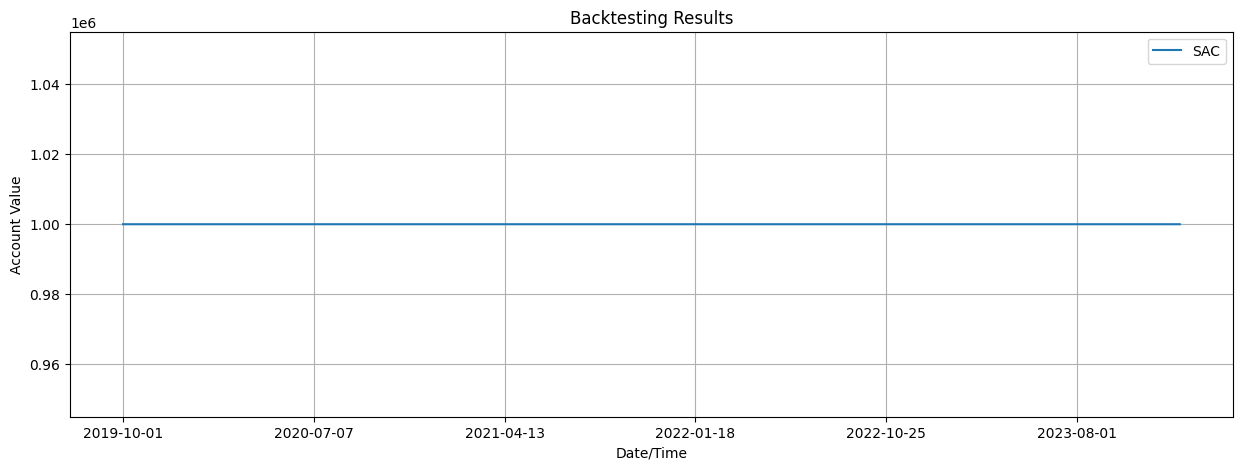

Backtesting complete.
Processing actions...
Plotting results...


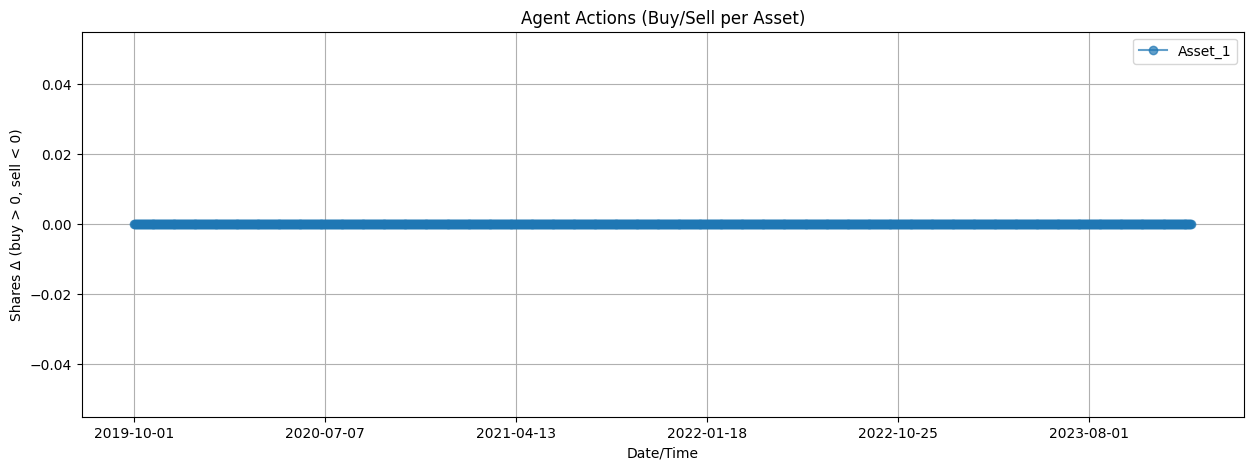

In [43]:
agent = DRLAgent(env=env_train)


sac_model_kwargs = dict(
    device="cuda",
    batch_size=256,
    buffer_size=100_000,
    learning_rate=1e-3,
    learning_starts=200,
    target_update_interval=1,
    ent_coef="auto_1.0",
    use_sde=True,
    sde_sample_freq=4,
)

a2c_model_kwargs = dict(
    device="cuda",
)

ppo_model_kwargs = dict(
    device="cuda",
)

base_config = {
    "log_dir": "./train_logs/base",
    "n_envs": 1,  # number of parallel environments to use for training
    "checkpoint": None,  # path to a checkpoint to load from
    "checkpoint_freq": 10000,  # save a model checkpoint every _ steps
    "eval_freq": 5000,  # evaluate the model every _ steps
    "n_eval_episodes": 10,  # number of episodes to evaluate the model on
    "n_train_timesteps": int(2e3),  # total number of training steps
    "verbose_training": False,
    # RL PARAMETERS (all set to defaults right now, except for seed)
    # "policy_args": {
    #     "net_arch": [64, 64],
    #     "activation_fn": nn.ReLU,
    # },
    "model_kwargs": {},
}

policy_kwargs = None

sac_fifo_config = copy.deepcopy(base_config)
sac_fifo_config["log_dir"] = "./train_logs/sac_fifo_config"
sac_fifo_config["policy_kwargs"] = policy_kwargs
sac_fifo_config["model_kwargs"]["replay_buffer_class"] = ReplayBuffer

sac_ser_config = copy.deepcopy(base_config)
sac_ser_config["log_dir"] = "./train_logs/sac_ser_config"
sac_ser_config["policy_kwargs"] = policy_kwargs
sac_ser_config["model_kwargs"]["replay_buffer_class"] = SERReplayBuffer
replay_buffer_kwargs = {
    "strategy": "coverage",
    "long_mem_size": 20_000
}
sac_ser_config["model_kwargs"]["replay_buffer_kwargs"] = replay_buffer_kwargs


a2c_fifo_config = copy.deepcopy(base_config)
a2c_fifo_config["log_dir"] = "./train_logs/a2c_fifo_config"
a2c_fifo_config["policy_kwargs"] = policy_kwargs


ppo_fifo_config = copy.deepcopy(base_config)
ppo_fifo_config["log_dir"] = "./train_logs/ppo_fifo_config"
ppo_fifo_config["policy_kwargs"] = policy_kwargs


IPython.display.clear_output(wait=True)
gc.collect()
tqdm._instances.clear()

model_sac = train_rl(agent, env_train, env_eval, "sac", sac_fifo_config)
plot_model(model_sac, e_eval_gym, deterministic=True)

# model_sac_ser = train_rl(agent, env_train, env_eval, "sac", sac_ser_config)
# plot_model(model_sac_ser, e_eval_gym, deterministic=True)

# model_a2c = train_rl(agent, env_train, env_eval, "a2c", a2c_fifo_config)
# plot_model(model_a2c, e_eval_gym, deterministic=True)

# model_ppo = train_rl(agent, env_train, env_eval, "ppo", ppo_fifo_config)
# plot_model(model_ppo, e_eval_gym, deterministic=True)